In [1]:
!pip install -Uqq timm

In [2]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
import timm
from fastai.vision.all import *
from fastai.imports import *

set_seed(291)

In [4]:
arch = "resnet18"
path = Path("/kaggle/input/generating-patches/ratio0.1_patches50_256x/")
files = get_image_files(path)

In [5]:
ptidx_unique = np.unique(np.array([str(x).split("/")[-2] for x in files]))
valid = np.random.choice(ptidx_unique, size=int(len(ptidx_unique)*0.15), replace=False)

splitter = FuncSplitter(lambda o: str(o).split(os.path.sep)[-2] in valid)

aug_transforms = [Dihedral(p=1.0), Contrast(0.1), Brightness(0.1), Zoom(), Warp(magnitude=0.1)]

cbs = [EarlyStoppingCallback(min_delta=0.001, patience=4)]

loss_func = LabelSmoothingCrossEntropy(weight=torch.tensor([0.5,2]).float().cuda())
metrics = [error_rate, RocAucBinary()]

In [6]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=splitter,
                 get_y=lambda x: 1 if "MALIGNANT" in str(x) else 0,
                 batch_tfms=[*aug_transforms, Normalize.from_stats(*imagenet_stats)],
               ).dataloaders(path, bs=64, shuffle=True)

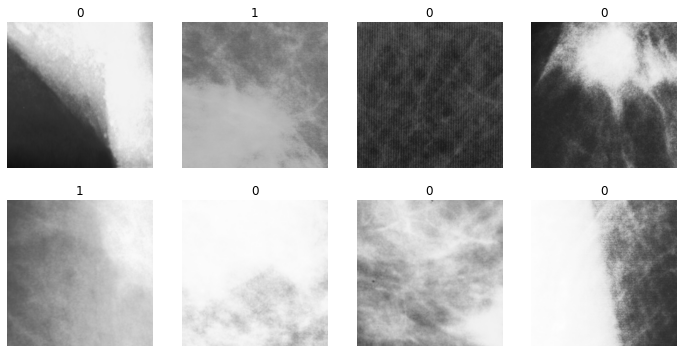

In [7]:
dls.show_batch(max_n=8)

In [8]:
learn = vision_learner(dls, arch, metrics=metrics, loss_func=loss_func).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [9]:
learn.summary()

Sequential (Input shape: 64 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [10]:
learn.model[-1][3].p = 0.0
learn.model[-1][7].p = 0.0

SuggestedLRs(valley=0.0002290867705596611)

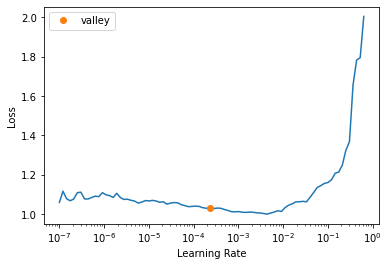

In [11]:
learn.lr_find()

In [12]:
learn.fit(100, 1e-2, cbs=[*cbs, SaveModelCallback(with_opt=True, fname="one_cycle_1"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-6)])
learn.load("one_cycle_1")

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.606793,0.695365,0.462881,0.719155,28:27
1,0.578623,0.732284,0.533403,0.751959,29:13
2,0.573714,0.624011,0.319033,0.752487,04:38
3,0.557269,0.671629,0.400981,0.744289,04:27
4,0.554395,0.698403,0.426148,0.768539,04:27
5,0.545156,0.670099,0.377077,0.775585,04:27
6,0.534514,0.669623,0.393691,0.779527,04:27


Better model found at epoch 0 with valid_loss value: 0.6953654885292053.
Better model found at epoch 2 with valid_loss value: 0.6240106821060181.
Epoch 4: reducing lr to 0.001
Epoch 6: reducing lr to 0.0001
No improvement since epoch 2: early stopping


SuggestedLRs(valley=3.311311274956097e-06)

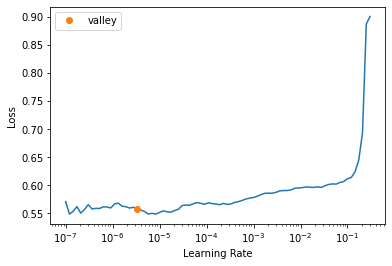

In [13]:
learn.unfreeze()
learn.lr_find()

In [14]:
learn.fit(100, 1e-5, cbs=[*cbs, SaveModelCallback(with_opt=True, fname="one_cycle_2"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-9)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.545777,0.642144,0.373431,0.779239,04:55
1,0.538825,0.653360,0.401612,0.789041,05:01
2,0.530747,0.642103,0.371258,0.780949,04:59
3,0.526880,0.646233,0.388153,0.785212,05:01
4,0.525303,0.646806,0.393481,0.785738,04:56


Better model found at epoch 0 with valid_loss value: 0.6421443819999695.
Better model found at epoch 2 with valid_loss value: 0.6421032547950745.
Epoch 2: reducing lr to 1.0000000000000002e-06
Epoch 4: reducing lr to 1.0000000000000002e-07
No improvement since epoch 0: early stopping


In [15]:
# learn.load("model")
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(7,7))
# interp.plot_top_losses(6)

In [16]:
# learn = vision_learner(dls, arch, metrics=metrics, loss_func=loss_func).to_fp16()

# learn.lr_find()

In [17]:
# learn.fit(100, 0.01, cbs=[*cbs, SaveModelCallback(with_opt=True, fname="lr_scheduler_head"), ReduceLROnPlateau(min_delta=0.01, patience=2)])

In [18]:
# learn.unfreeze()
# learn.lr_find()

In [19]:
# learn.fit(100, 0.01, cbs=[*cbs, SaveModelCallback(with_opt=True, fname="lr_scheduler_body"), ReduceLROnPlateau(min_delta=0.01, patience=2)])